# Аналіз ефективності заходів безпеки дорожнього руху в Києві

Спочатку скачуємо і відкриваємо датасет з аваріями (він взятий [звідси](https://docs.google.com/spreadsheets/d/1Dk-oB-lXYNFzSMGUtO4iSUnYMWmLQnH9/edit#gid=291616867)):

In [1]:
import pandas as pd

data = pd.read_csv('DTP Kyiv 2016-2019.csv')
data.info()   #узагальнений опис даних, які є в таблиці

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20067 entries, 0 to 20066
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               8168 non-null   float64
 1   date             20067 non-null  object 
 2   time             20067 non-null  object 
 3   district         18812 non-null  object 
 4   street           20067 non-null  object 
 5   xtra             17335 non-null  object 
 6   type             20067 non-null  object 
 7   person           20067 non-null  object 
 8   injury           20067 non-null  object 
 9   dma_street_code  4314 non-null   float64
 10  dma_str_house    1391 non-null   object 
 11  dma_lat          757 non-null    float64
 12  dma_lng          757 non-null    float64
 13  drv_street_code  4062 non-null   float64
 14  full_address     1391 non-null   object 
dtypes: float64(5), object(10)
memory usage: 1.5+ MB


Бачимо, що за три роки і п'ять місяців (від початку серпня $2016$ до кінця $2019$) поліція зафіксувала $8168$ аварій з $20067$ учасниками. Всі записи в таблиці містять інформацію про дату, час, вулицю, тип учасника (водій, пішохід тощо) та ушкодження. Це добре. В той же час, поле _xtra_ відсутнє у трохи менше ніж $3000$ записах, і це не дуже добре оскільки це означає, що точну адресу цих ДТП встановити не вдасться. Всі наступні поля рідко бувають заповненими і не дають нової інформації, давайте видалимо їх. Також видалимо не дуже потрібне поле _district_ і додамо поле _year_ для зручності:

In [2]:
data.drop(columns = ['district', 'dma_street_code', 'dma_str_house', 'dma_lat',
                     'dma_lng', 'drv_street_code', 'full_address'], inplace = True)
data['year'] = data.apply (lambda row: int(row['date'][-4:]), axis=1)

set(data['injury'].values)   #як саме виглядають описи ушкоджень?

{'Без ушкоджень',
 'Легко травмований',
 'Помер на місці ДТП',
 'Помер по дорозі в лікарню',
 'Помер у лікарні протягом 30 діб',
 'Тяжко травмований'}

## Задротська частина

Ми будемо бачити різну кількість ДТП до та після запровадження певного рішення. Але як переконатися, що зміна кількості ДТП - не випадковість? Для цього потрібно перевірити статистичну гіпотезу про те, що ймовірності ДТП до та після дійсно різні. Відомо, що за фіксованих умов час очікування наступного ДТП дуже добре моделюється [експоненційним розподілом](https://en.wikipedia.org/wiki/Exponential_distribution) (але кількість постраждалих - ні, саме тому при перевірці гіпотези ми дивитимемося на кількість ДТП, але виводити будемо кількість постраждалих як більш важливий показник). Будемо перевіряти, чи не перетинаються $90\%$ - довірчі інтервали для матсподівання, відповідну формулу можна знайти [тут](https://en.wikipedia.org/wiki/Exponential_distribution#Confidence_intervals).

In [3]:
from scipy.stats import chi2

def do_confints_overlap(time1, dtp1, time2, dtp2, alpha = 0.1):
    lower1, upper1 = ((2 * time1) / chi2.ppf(q = 1 - alpha / 2, df = 2 * dtp1),
                      (2 * time1) / chi2.ppf(q = alpha / 2, df = 2 * dtp1))
    lower2, upper2 = ((2 * time2) / chi2.ppf(q = 1 - alpha / 2, df = 2 * dtp2),
                      (2 * time2) / chi2.ppf(q = alpha / 2, df = 2 * dtp2))
    
    return (lower1 - upper2) * (lower2 - upper1) > 0   #перевірка на перетин інтервалів

## Зниження максимальної дозволеної швидкості

Починаючи з $1$ січня $2018$ року максимальна швидкість у населених пунктах була [знижена](https://www.pravda.com.ua/news/2018/01/1/7167256/) з $60$ до $50$ км/год. Та чи допомогло це? Давайте подивимось на кількість смертельних випадків, тяжких та легких травм.

In [4]:
death_labels = ['Помер на місці ДТП', 'Помер по дорозі в лікарню', 'Помер у лікарні протягом 30 діб']
speed_60 = [len(data[(data['year'] < 2018) & (data['injury'].isin(death_labels))]),
            len(data[(data['year'] < 2018) & (data['injury'] == 'Тяжко травмований')]),
            len(data[(data['year'] < 2018) & (data['injury'] == 'Легко травмований')]),
            data[(data['year'] < 2018)]['id'].count()]
speed_50 = [len(data[(data['year'] >= 2018) & (data['injury'].isin(death_labels))]),
            len(data[(data['year'] >= 2018) & (data['injury'] == 'Тяжко травмований')]),
            len(data[(data['year'] >= 2018) & (data['injury'] == 'Легко травмований')]),
            data[(data['year'] >= 2018)]['id'].count()]

years_60, years_50 = 1 + 151 / 356, 2   #час (в роках), протягом якого швидкість була 60 і 50 відповідно
stat_signif = [do_confints_overlap(years_50, i, years_60, j) for i, j in zip(speed_50, speed_60)]

def accidents_on_street(streetname):
    for _, row in data.iterrows():
        if streetname in row['street']:
            print(row['date'], row['street'], row['xtra'], row['type'], row['injury'], row['person'])

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12, 8]
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 14})

In [12]:
#наступний код генерує візуалізації

def form_text(dtp_per_year_1, dtp_per_year_2, 
              year, significant):
    text = ' '
    if year:
        text += str(int(dtp_per_year_1))
    else:
        text += str("{0:.2f}".format(dtp_per_year_1))
    
    if (dtp_per_year_2 > 0 and dtp_per_year_1 > 0):
        text += ' (' + str(int(100 * (dtp_per_year_1 / dtp_per_year_2 - 1))) + '%)'
        if significant:
            text += '*'
            
    return text

def plot_results(dtps, times, lab, title, statsign, year, colors = ['red', 'tomato', 'coral', 'salmon'], 
                 labels = ['Загиблі', 'Тяжко травмовані', 'Легко травмовані', 'Всього ДТП']):
    for n, color in enumerate(colors):
        plt.barh(np.arange(dtps.shape[0]) + 0.2 * n, width = dtps[:, n] / times, 
                 height = 0.2, color = color, label = labels[n], tick_label = lab)
    
    for i, dtp_ in enumerate(dtps):
        for j, dtp in enumerate(dtp_):
            text = form_text(dtp / times[i], 0 if i % 2 == 1 else (dtps[i + 1, j] / times[i + 1]), 
                             year, not statsign[int(i / 2), j])
            plt.text(dtp / times[i], i + j * 0.2, text, ha='left', va='center')
    
    plt.title(title)
    plt.xlabel('Кількість, на рік')
    plt.legend(loc = 4)
    plt.show()

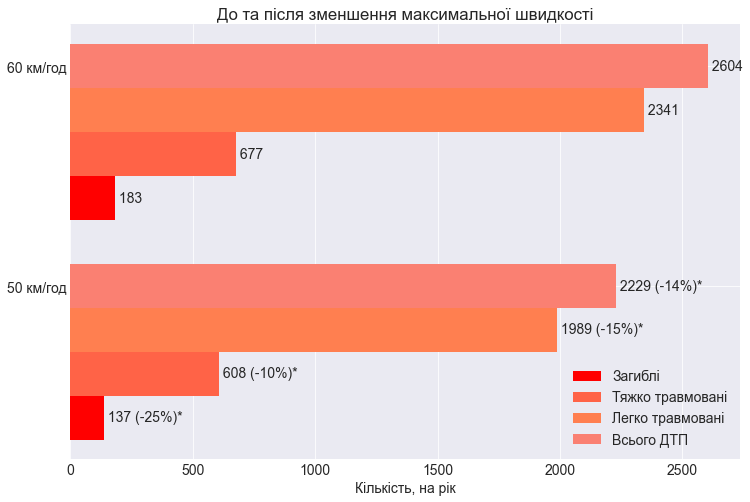

In [13]:
plot_results(np.array([speed_50, speed_60]), np.array([years_50, years_60]), ['50 км/год', '60 км/год'],
             'До та після зменшення максимальної швидкості', np.array([stat_signif]), True)

Зірочкою тут і далі позначено ті цифри, зміна яких є статистично значимою. Можливо, існують і відмінні від зменшення максимальної швидкості джерела зменшення смертності, травматичності і загальної кількості ДТП на дорогах Києва. Але враховуючи те, наскільки схожа статистика за $2016$ і $2017$, а також статистика за $2018$ і $2019$ роки, це зменшення відбулося скачкоподібно, саме між $2017$ і $2018$ роками. Є всі підстави вважати, що __зменшення максимальної швидкості в містах позитивно вплинуло на безпеку на дорогах__. Зауважте, що найбільше знизилась смертність, а найменше - кількість тяжко травмованих жертв ДТП. Ймовірно, частина з них могла б не вижити за обмеження в $60$ км/год. Кількість легко травмованих та загальна кількість ДТП також показали статистично значущий спад.

## Острівці безпеки

Тепер, коли ми розуміємо, що безпека на київських дорогах була суттєво різною до та після $1$ січня $2018$ року, було б неправильно оцінювати ефективність локальних інженерних рішень, використовуючи всі наявні дані (тоді б ми найімовірніше завищили цю ефективність). Отже, надалі якщо щось було встановлено до початку $2018$ року, до уваги будуть братись лише дані до початку $2018$ року і навпаки. Також будуть братися до уваги не лише ДТП безпосередньо на переході, який розглядається, але й на ділянці дороги, що розташована найближче саме до цього переходу.

Я розгляну всі острівці безпеки, дату встановлення яких можна більш-менш точно визначити. Далі доведеться вручну перебрати всі ДТП на потрібній нам вулиці, результати представлені далі:

In [14]:
def plot_from_matrix(matrix, text_before, text_after, title):
    dtp = np.sum(matrix[:, 2:], axis = 0).reshape(2, 4)
    years_before = np.sum(matrix[:, 1])
    years_after = np.sum(matrix[:, 0])
    stat_signif = [do_confints_overlap(years_after, i, years_before, j) for i, j in zip(dtp[0], dtp[1])]

    plot_results(dtp, [years_after, years_before], [text_before, text_after],
                 title, np.array([stat_signif]), False)

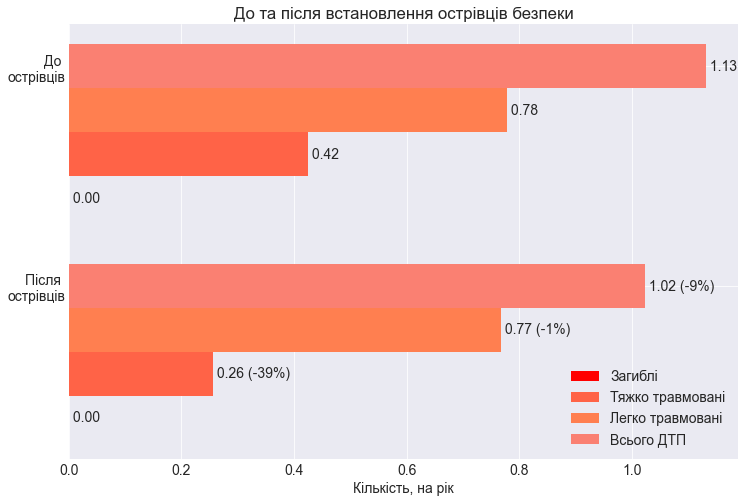

In [16]:
#в кожному рядку таблиці - кількість років з острівцем-кількість років без нього-статистика по ДТП після і до
islands = np.array([[1, 1, 0, 1, 3, 4, 0, 0, 0, 0],   #Зої Гайдай, 7
                    [1, 1, 0, 0, 0, 0, 0, 0, 1, 1],   #Героїв Дніпра, 38
                    [122/365, 1 + 243/365, 0, 0, 0, 0, 0, 3, 4, 6],   #Ревуцького, 5-13
                    [1 + 131/365, 234/365, 0, 0, 0, 0, 0, 0, 1, 1],   #Грушевського, 4
                    [257/365, 1 + 108/365, 0, 0, 1, 1, 0, 0, 3, 3],   #Миру, 17
                    [1, 1, 0, 1, 0, 1, 0, 0, 0, 0],   #Йорданська, 20
                    [1, 1, 0, 0, 2, 2, 0, 1, 0, 1],   #Малиновського, 27
                    [257/365, 1 + 108/365, 0, 0, 0, 0, 0, 0, 0, 0],   #Кловський, 8
                    [106/356, 1 + 250/365, 0, 0, 0, 0, 0, 2, 1, 3],   #Васильківська, 90
                    [76/365, 1 + 280/356, 0, 0, 0, 0, 0, 0, 1, 1],    #Ризька, 6
                    [76/356, 1 + 280/365, 0, 0, 0, 0, 0, 0, 0, 0]])    #Стеценка
    
plot_from_matrix(islands, 'Після \nострівців', 'До \nострівців', 'До та після встановлення острівців безпеки')

Тут кількість усереднена по всім розглянутим переходам. Виглядає непогано, але звісно, даних замало, щоб щось стверджувати напевно - жодна зі змін не є статистично значущою. Дійсно, прогнозувати майбутню аварійність ці дані не дозволяють - взимку $2020$ на одному з переходів, обладнаним острівцем, [насмерть збили жінку](https://espreso.tv/news/2020/02/11/dtp_u_kyyevi_vodiy_zbyv_nasmert_zhinku_na_pishokhidnomu_perekhodi). Також цей аналіз не враховує обставини встановлення конкретних острівців, доводиться агрегувати всі дані щоб отримати хоч якийсь усереднений результат.

## "Лежачі поліцейські"

Встановленням "лежачих поліцейських" займається КП "ЦОДР". На своїй [фейсбук-сторінці](https://www.facebook.com/kyivtrafficmanagement) вони часто звітують про виконані роботи. Ігноруючи "поліцейських", встановлених у дворах та тих, дату встановлення яких визначити не виходить, маємо таке:

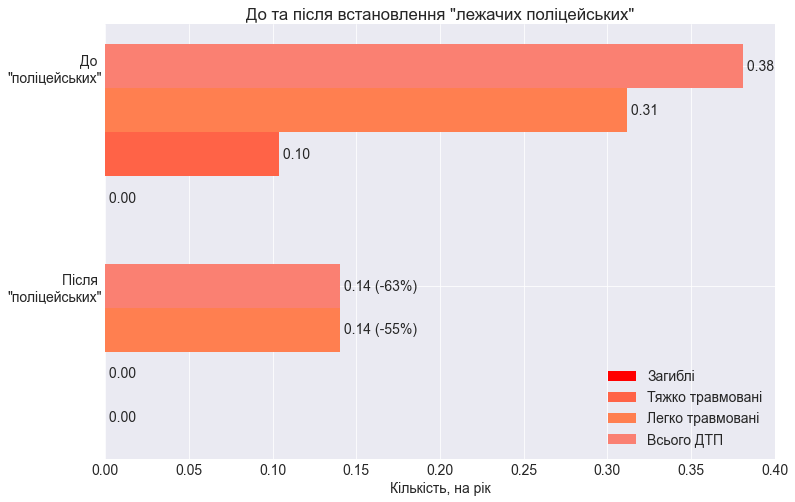

In [17]:
#в кожному рядку таблиці - кількість років з "поліцейським"-кількість років без нього-статистика по ДТП після і до
bumps =  np.array([[254/365, 1 + 111/365, 0, 0, 0, 0, 0, 0, 0, 0],  #Челябінська, 1
                   [249/365, 1 + 116/365, 0, 0, 0, 0, 0, 0, 0, 0],  #Лісова, 64-66
                   [231/365, 1 + 134/365, 0, 0, 0, 0, 0, 0, 0, 0],  #Тороповського, 49/5
                   [208/365, 1 + 157/365, 0, 0, 0, 0, 0, 0, 1, 1],  #Стуса, 23
                   [204/365, 1 + 161/365, 0, 0, 0, 0, 0, 0, 0, 0],  #Драгомирова, 10-А
                   [200/365, 1 + 165/365, 0, 0, 0, 0, 0, 0, 3, 3],  #Вокзальна, 1
                   [200/365, 1 + 165/365, 0, 0, 0, 0, 0, 0, 0, 0],  #пров. Хоткевича, 6
                   [191/365, 1 + 174/365, 0, 0, 0, 0, 0, 0, 0, 0],  #Котарбінського, 20
                   [178/365, 1 + 187/365, 0, 0, 0, 0, 0, 0, 1, 1],  #Лаврухіна, 10
                   [172/365, 1 + 193/365, 0, 0, 0, 0, 0, 0, 1, 1],  #Білицька, 12
                   [157/365, 1 + 208/365, 0, 0, 0, 0, 0, 0, 0, 0],  #Ломоносова, 26
                   [108/365, 1 + 257/365, 0, 0, 1, 1, 0, 2, 2, 3],  #Григоренка, 9-18
                   [91/365, 1 + 276/365, 0, 0, 0, 0, 0, 0, 0, 0],  #Данченка/Брестська
                   [35/365, 1 + 330/365, 0, 0, 0, 0, 0, 0, 0, 0],  #Товарна/Дружби народів
                   [34/365, 1 + 331/365, 0, 0, 0, 0, 0, 0, 1, 1],  #Бульварно-Кудрявська, 2
                   [32/365, 1 + 333/365, 0, 0, 0, 0, 0, 0, 0, 0],  #Кіото, 9
                   [32/365, 1 + 333/365, 0, 0, 0, 0, 0, 0, 0, 0],  #Сєркова, 14-Є
                   [27/365, 1 + 338/365, 0, 0, 0, 0, 0, 1, 0, 1]])  #Корольова, 7

plot_from_matrix(bumps, 'Після \n"поліцейських"', 'До \n"поліцейських"', 'До та після встановлення "лежачих поліцейських"')

Дуже мала вибірка не дозволяє зробити статистично значущих висновків, але попередньо "лежачі поліцейські" здаються дуже ефективними. Їх багато критикують, іноді пропонуючи підняті на рівень тротуару переходи як альтернативу. Але на жаль такі рішення не стали популярними в Києві, тож огляд їх ефективності зробити не вийде.

## Пластикові школярі

[Проєкт Громадського Бюджету-2019](https://gb.kyivcity.gov.ua/projects/archive/10/show/1000), що передбачав встановлення ростових фігур школярів біля небезпечних нерегульованих переходів на Сирці, переміг на голосуванні і був реалізований в кінці вересня $2019$ року. Чи допомогло це?

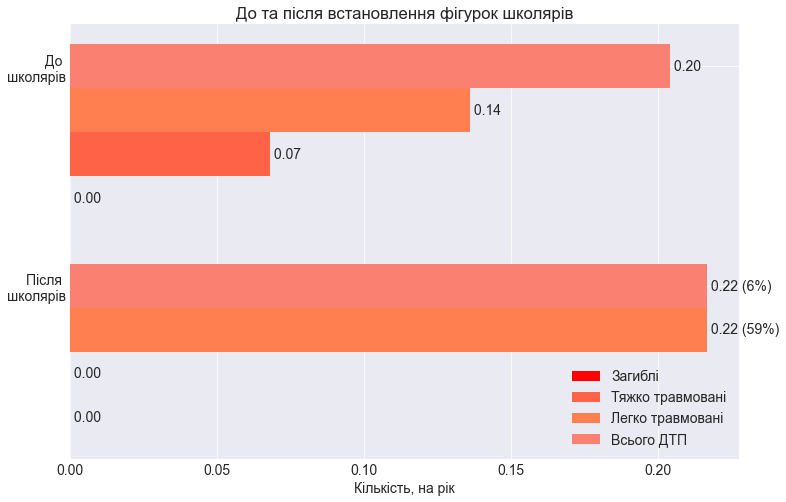

In [18]:
#в кожному рядку таблиці - кількість років з муляжами-кількість років без них-статистика по ДТП після і до
kids = np.array([[99/365, 1 + 266/365, 0, 0, 0, 0, 0, 0, 0, 0],  #Бакинська, 12
                 [99/365, 1 + 266/365, 0, 0, 1, 1, 0, 1, 1, 2],  #Ольжича, 3
                 [99/365, 1 + 266/365, 0, 0, 0, 0, 0, 0, 0, 0],  #Ольжича/Берлинського
                 [99/365, 1 + 266/365, 0, 0, 0, 0, 0, 0, 0, 0],  #Берлинського/Сальського
                 [99/365, 1 + 266/365, 0, 0, 0, 0, 0, 0, 0, 0],  #Сальського/Вавилових
                 [99/365, 1 + 266/365, 0, 0, 0, 0, 0, 0, 0, 0],  #Житкова/Глушка
                 [99/365, 1 + 266/365, 0, 0, 0, 0, 0, 0, 0, 0],  #Вавилових/Глушка
                 [99/365, 1 + 266/365, 0, 0, 0, 0, 0, 1, 1, 2],  #Берлинського/Глушка
                 [99/365, 1 + 266/365, 0, 0, 0, 0, 0, 0, 0, 0],  #Житкова/Щусєва
                 [99/365, 1 + 266/365, 0, 0, 0, 0, 0, 0, 1, 1],  #Ризька/Грекова
                 [99/365, 1 + 266/365, 0, 0, 0, 0, 0, 0, 0, 0],  #Парково-Сирецька, 5
                 [99/365, 1 + 266/365, 0, 0, 0, 0, 0, 0, 0, 0],  #Парково-Сирецька, 9
                 [99/365, 1 + 266/365, 0, 0, 0, 0, 0, 0, 0, 0],  #Парково-Сирецька/Гонти
                 [99/365, 1 + 266/365, 0, 0, 0, 0, 0, 0, 0, 0],  #Табірна/Артилерійський
                 [99/365, 1 + 266/365, 0, 0, 0, 0, 0, 0, 0, 0],  #Сікорського, 6
                 [99/365, 1 + 266/365, 0, 0, 0, 0, 0, 0, 0, 0],  #Берлинського/Грекова
                 [99/365, 1 + 266/365, 0, 0, 0, 0, 0, 0, 1, 1]])  #Сікорського/Жабаєва

plot_from_matrix(kids, 'Після \nшколярів', 'До \nшколярів', 'До та після встановлення фігурок школярів')

Знову, жодних впевнених висновків зробити не можна, адже до кінця $2019$ року кожен зі школярів простояв лише трішки більше трьох місяців і статистика про аварійність після їх встановлення складається лише з одного ДТП. Побачивши статистику за $2020$ рік, можна було б сказати більше.

## Висновки

1) Обмеження максимальної швидкості дійсно робить місто безпечнішим. Навіть коли контроль за дотриманням цього обмеження слабкий.

2) З приводу острівців безпеки, попередньо можна зробити висновок про їх ефективність, але зменшення кількості ДПТ не є дуже значним. Було б неправильно думати, що київські переходи, обладнані острівцями, є справді безпечними. Комунальним службам не варто про них забувати, а міським активістам імовірно варто просувати посилення острівців безпеки іншими засобами заспокоєння руху на найбільш проблемних нерегульованих переходах.

3) "Лежачі поліцейські" попередньо виглядають дійсно ефективними в плані безпеки руху (хоча можливості коректно порівняти їх з піднятими переходами на основі даних, що маємо, немає).

4) Я не знаю, чи працюють пластикові макети дітей. Треба чекати, доки назбирається ще даних.